## ENDG 511 Project Experiment

This notebook will showcase the project experiment with the intention of expanding on the RODNet implementations to apply concepts learned in the course such as pruning, quantization, and clustering for TinyAI and multibranching architectures for FastAI.

### Import Required Dependencies

In [16]:
# RodNet
from rodnet.core.post_processing import (
    ConfmapStack, 
    post_process, 
    post_process_single_frame, 
    write_dets_results, 
    write_dets_results_single_frame, 
    lnms, 
    ops
)
from rodnet.utils.visualization import (
    visualize_train_img, 
    visualize_test_img_wo_gt, 
    visualize_confmap, 
    visualize_test_img
)
from rodnet.utils.load_configs import (
    load_configs_from_file, 
    parse_cfgs, 
    update_config_dict
)
from rodnet.utils.solve_dir import create_dir_for_new_model
from rodnet.datasets.collate_functions import cr_collate
from rodnet.datasets.CRDataset import CRDataset
from cruw import CRUW

# PyTorch
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch

# General
import numpy as np
import datetime
import pickle
import json
import os

### Define Project Paths

If you don't prefer to change the following paths below, please visit ReadMe and follow instructions for proper setup of the project directories.

In [17]:
# Date and time of experiment
today = datetime.datetime.now().strftime('%Y-%m-%d--%H:%M:%S').replace(":", "_")
print(f"Time of experiment is: {today}")

Time of experiment is: 2024-03-20--18_18_42


In [18]:
config_fie = os.path.join(os.path.dirname(os.path.realpath('__file__')), "configs/config_rodnet_cdc_win16.py")

# This dataset contains pkl file annotations that were converted.
converted_dataset = os.path.join(os.path.dirname(os.path.realpath('__file__')), "ROD2021/converted_new")

# This is the path to store the trained model weights in a pkl file. If this does not exist, this will be created.
train_model_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), f"checkpoints/{today}")

# This is the path to store the model results, along with the history (JSON), config (JSON) and the plots (images).
test_res_dir = os.path.join(os.path.dirname(os.path.realpath('__file__')), f"results/{today}")

### Define Parameters

In [19]:
# This is by default.
sensor_config_name = "sensor_config_rod2021"
noise_channel = False
device = torch.device(torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu:0"))

### Load Project Paths

In [20]:
if not os.path.exists(config_fie):
    raise FileNotFoundError(f"The configuration file does not exist at {config_fie}")
config_dict = load_configs_from_file(config_fie)

if not os.path.exists(config_dict["dataset_cfg"]["base_root"]):
    path = config_dict['dataset_cfg']['base_root']
    raise FileNotFoundError(f"The configuration path does not exist: {path}")

if not os.path.exists(config_dict["dataset_cfg"]["data_root"]):
    path = config_dict['dataset_cfg']['data_root']
    raise FileNotFoundError(f"The configuration path does not exist: {path}")

if not os.path.exists(config_dict["dataset_cfg"]["anno_root"]):
    path = config_dict['dataset_cfg']['anno_root']
    raise FileNotFoundError(f"The configuration path does not exist: {path}")

model_cfg = config_dict['model_cfg']

if not os.path.exists(train_model_path):
    os.makedirs(train_model_path)

if not os.path.exists(test_res_dir):
    os.makedirs(test_res_dir)

### Load Dataset

In [21]:
dataset = CRUW(data_root=config_dict['dataset_cfg']['base_root'], 
               sensor_config_name=sensor_config_name)
radar_configs = dataset.sensor_cfg.radar_cfg
range_grid = dataset.range_grid         
angle_grid = dataset.angle_grid  

crdata_train = CRDataset(
    data_dir=converted_dataset, 
    dataset=dataset, 
    config_dict=config_dict,
    split='train',
    noise_channel=noise_channel
)
print(f"The total dataset samples: {len(crdata_train)}")

n_class = dataset.object_cfg.n_class          
n_epoch = config_dict['train_cfg']['n_epoch']   
batch_size = config_dict['train_cfg']['batch_size'] 
lr = config_dict['train_cfg']['lr']
train_configs = config_dict['train_cfg']
test_configs = config_dict['test_cfg']
win_size = train_configs['win_size']

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:07<00:00,  1.69it/s]

The total dataset samples: 3058


### Split Dataset into Train and Validation

In [22]:
test_data, validation_data = torch.utils.data.random_split(crdata_train,[2358,700])

### Define Dataset Loaders

In [23]:
tdataloader = DataLoader(
    test_data, 
    batch_size, 
    shuffle=True, 
    num_workers=0, 
    collate_fn=cr_collate)
vdataloader = DataLoader(
    validation_data, 
    batch_size=1, 
    shuffle=True, 
    num_workers=0, 
    collate_fn=cr_collate)

### Import Model Dependencies

In [30]:
import imp
import getModel
imp.reload(getModel)
from getModel import RODNetBase, RODNetBranched
import trainModel
imp.reload(trainModel)
from trainModel import TrainBranchedHandler, TrainBaseHandler

### Load Base Model

In [32]:
rodnet_base = RODNetBase(in_channels=2, n_class=n_class).to(device)
base_optimizer = optim.Adam(rodnet_base.parameters(), lr=lr)
base_criterion = nn.BCELoss()
base_scheduler = StepLR(base_optimizer, step_size=config_dict['train_cfg']['lr_step'], gamma=0.1)

base_trainer = TrainBaseHandler(
    rodnet_base,
    base_criterion,
    base_optimizer,
    device,
    base_scheduler,
    n_epoch
)

In [33]:
rodnet_base.print_summary()

Number of encoder parameters: 28601088
Number of decoder long parameters: 5919172


### Load Branched Model

In [35]:
rodnet_branched = RODNetBranched(in_channels=2, n_class=n_class).to(device)
branched_optimizer = optim.Adam(rodnet_branched.parameters(), lr=lr)
branched_criterion = nn.BCELoss()
branched_scheduler = StepLR(branched_optimizer, step_size=config_dict['train_cfg']['lr_step'], gamma=0.1)

branched_trainer = TrainBranchedHandler(
    rodnet_branched,
    branched_criterion,
    branched_optimizer,
    device,
    branched_scheduler,
    n_epoch
)

In [36]:
rodnet_branched.print_summary()

Number of encoder parameters: 6481152
Number of decoder short parameters: 1200452
Number of decoder long parameters: 28038596


### Load Prune Model

In [ ]:
# TODO: Implement

### Load Quantization Model

In [ ]:
# TODO: Implement

### Load Clustering Model

In [ ]:
# TODO: Implement

***Train base Model***

In [37]:
rodNet_v0, history_v0 = base_trainer.train(tdataloader, train_model_path)
base_trainer.save_metrics(test_res_dir)

# TODO: Report Precision, Recall, Accuracy

In [14]:
print(history_v0)

{'train': {'loss': [0.11253852646924177, 0.026596574266677945, 0.024204503046151377, 0.02297205110830334, 0.022205296422402234]}}


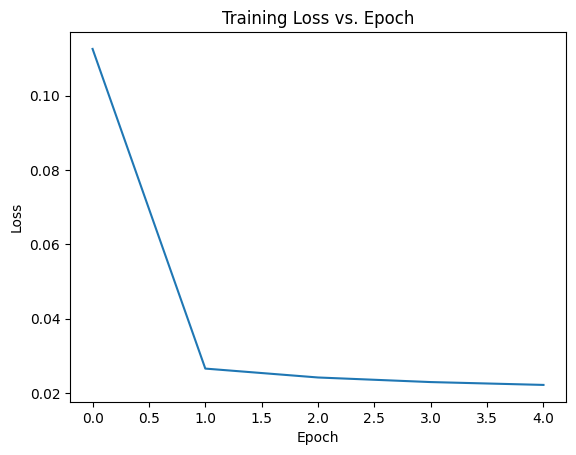

In [13]:
total_loss = history_v0['train']['loss']
epochs = np.array([i for i in range(n_epoch)])
plt.plot(epochs, total_loss)
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

***Train multibranch model***

In [15]:
rodNet_v1, history_v1 = M_v1.train(tdataloader,train_model_path)

epoch 1 --> shortbranchloss: 0.190, longbranchloss: 0.116, totalloss: 0.153
saving current epoch model ...
epoch 2 --> shortbranchloss: 0.033, longbranchloss: 0.029, totalloss: 0.031
saving current epoch model ...
epoch 3 --> shortbranchloss: 0.028, longbranchloss: 0.026, totalloss: 0.027
saving current epoch model ...
epoch 4 --> shortbranchloss: 0.026, longbranchloss: 0.025, totalloss: 0.025
saving current epoch model ...
epoch 5 --> shortbranchloss: 0.024, longbranchloss: 0.024, totalloss: 0.024
saving current epoch model ...


In [30]:
total_loss = history_v1['T']['train']['loss']
short_branch_loss = history_v1['1']['train']['loss']
long_branch_loss = history_v1['2']['train']['loss']
epochs = np.array([i for i in range(n_epoch)])
plt.plot(epochs, total_loss, label='Total')
plt.plot(epochs,short_branch_loss, label='Short Branch')
plt.plot(epochs,long_branch_loss, label='Long Branch')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history_v1' is not defined

In [1]:
from cruw.eval import evaluate_rodnet_seq
from cruw.eval.rod.rod_eval_utils import accumulate, summarize
from cruw.eval.rod.load_txt import read_gt_txt, read_sub_txt, read_rodnet_res
from cruw.eval.rod.rod_eval_utils import compute_ols_dts_gts, evaluate_img, accumulate, summarize

In [20]:
rod_v0 = ROD_V0(in_channels=2, n_class=n_class).to(device)
rod_v0.load_state_dict(torch.load(os.path.join(train_model_path,'base_epoch_0{}_final.pkl'.format(n_epoch))))
rod_v0.eval()
validation_loss_class_0 = []
validation_loss_class_1 = []
validation_loss_class_2 = []
ols_ans = []
with torch.no_grad():
    for iter, data_dict in enumerate(vdataloader):
        data = data_dict['radar_data'].to(device)
        confmap_gt = data_dict['anno']['confmaps'].to(device)
        seq_name = data_dict['seq_names'][0]
        start_frame = data_dict['start_frame'].item()
        end_frame = data_dict['end_frame'].item()
        confmap_pred = rod_v0(data.float())
        loss_class_0 = criterion_v0(confmap_pred[:,0,:,:,:], confmap_gt[:,0,:,:,:].float()).item()
        loss_class_1 = criterion_v0(confmap_pred[:,1,:,:,:], confmap_gt[:,1,:,:,:].float()).item()
        loss_class_2 = criterion_v0(confmap_pred[:,2,:,:,:], confmap_gt[:,2,:,:,:].float()).item()
        validation_loss_class_0.append(loss_class_0)
        validation_loss_class_1.append(loss_class_1)
        validation_loss_class_2.append(loss_class_2)
        pred = confmap_pred[0,:,0,:,:]
        pred = pred.cpu().detach().numpy()

        #print(seq_name)
        result = post_process_single_frame(pred, dataset, config_dict)
        
        seq_res_dir = os.path.join(test_res_dir_base, seq_name)
        if not os.path.exists(seq_res_dir):
            os.makedirs(seq_res_dir)
        f = open(os.path.join(seq_res_dir, 'rod_res.txt'), 'a')
        f.close()
        save_path = os.path.join(test_res_dir_base, seq_name, 'rod_res.txt')

        write_dets_results_single_frame(result, start_frame, save_path, dataset)
        
        gt_path = os.path.join('C:/Users/john.s/Documents/RodNet/ROD2021/annotations/train', seq_name.upper() + '.txt')
        data_path = os.path.join(dataset.data_root, 'sequences', gt_path.split('/')[-1][:-4])
        n_frame = len(os.listdir(os.path.join(data_path, dataset.sensor_cfg.camera_cfg['image_folder'])))
        gt_dets = read_gt_txt(gt_path, n_frame, dataset)
        sub_dets = read_rodnet_res(save_path, n_frame, dataset)
        olss_all = {(start_frame, catId): compute_ols_dts_gts(gt_dets, sub_dets, start_frame, catId, dataset) \
                    for catId in range(3)}
        ols_ans.append(olss_all)
   

Number of encoder parameters: 28601088
Number of decoder long parameters: 5919174
result=array([[  2.        ,  55.        , 104.        ,   0.35353833],
       [  2.        ,  53.        , 106.        ,   0.35153884],
       [  2.        ,  89.        ,  82.        ,   0.34254435],
       [  2.        ,  87.        ,  80.        ,   0.32396626],
       [  2.        ,  91.        ,  84.        ,   0.30017382],
       [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
       [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
       [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
       [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
       [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
       [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
       [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
       [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
       [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
 

TypeError: 'NoneType' object is not subscriptable

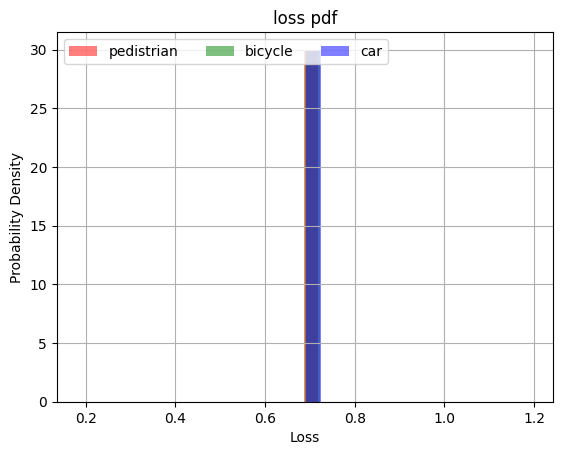

In [ ]:
plt.hist(np.round(np.array(validation_loss_class_0),3), bins=30, color='red', alpha=0.5, label='pedistrian',density=True)
plt.hist(np.round(np.array(validation_loss_class_1),3), bins=30, color='green', alpha=0.5, label='bicycle',density=True)
plt.hist(np.round(np.array(validation_loss_class_2),3), bins=30, color='blue', alpha=0.5, label='car',density=True)
plt.title('loss pdf')
plt.xlabel('Loss')
plt.ylabel('Probability Density')
plt.legend(loc='upper left', ncol=3)
plt.grid(True)
plt.show()

In [29]:
rod_v1 = ROD_V1(in_channels=2, n_class=n_class).to(device)
rod_v1.load_state_dict(torch.load(os.path.join(train_model_path,'multi_epoch_0{}_final.pkl'.format(n_epoch))))
rod_v1.eval()
val_loss_class_0_short = []
val_loss_class_1_short = []
val_loss_class_2_short = []
val_loss_class_0_long = []
val_loss_class_1_long = []
val_loss_class_2_long = []
early_exit_count = 0
ols_ans_1 = []
ols_ans_2 = []
early_exit_count = 0
with torch.no_grad():
    for iter, data_dict in enumerate(vdataloader):
        data = data_dict['radar_data'].to(device)
        confmap_gt = data_dict['anno']['confmaps'].to(device)
        seq_name = data_dict['seq_names'][0]
        start_frame = data_dict['start_frame'].item()
        end_frame = data_dict['end_frame'].item()
        confmap_preds_1,confmap_preds_2 = rod_v1(data.float())
        loss_1_class0, loss_2_class0 = criterion_v1(confmap_preds_1[:,0,:,:,:], confmap_gt[:,0,:,:,:].float()), criterion_v1(confmap_preds_2[:,0,:,:,:], confmap_gt[:,0,:,:,:].float())
        loss_1_class1, loss_2_class1 = criterion_v1(confmap_preds_1[:,1,:,:,:], confmap_gt[:,1,:,:,:].float()), criterion_v1(confmap_preds_2[:,1,:,:,:], confmap_gt[:,1,:,:,:].float())
        loss_1_class2, loss_2_class2 = criterion_v1(confmap_preds_1[:,2,:,:,:], confmap_gt[:,2,:,:,:].float()), criterion_v1(confmap_preds_2[:,2,:,:,:], confmap_gt[:,2,:,:,:].float())
        val_loss_class_0_short.append(loss_1_class0)
        val_loss_class_1_short.append(loss_1_class1)
        val_loss_class_2_short.append(loss_1_class2)
        val_loss_class_0_long.append(loss_2_class0)
        val_loss_class_1_long.append(loss_2_class1)
        val_loss_class_2_long.append(loss_2_class2)

        pred1 = confmap_preds_1[0,:,0,:,:].cpu().detach().numpy()
        pred2 = confmap_preds_2[0,:,0,:,:].cpu().detach().numpy()

        #print(seq_name)
        result1 = post_process_single_frame(pred1, dataset, config_dict)
        result2 = post_process_single_frame(pred2, dataset, config_dict)
        
        seq_res_dir = os.path.join(test_res_dir_multi, seq_name)
        if not os.path.exists(seq_res_dir):
            os.makedirs(seq_res_dir)
        f1 = open(os.path.join(seq_res_dir, 'rod_res_1.txt'), 'a')
        f2 = open(os.path.join(seq_res_dir, 'rod_res_2.txt'), 'a')
        f1.close()
        f2.close()
        save_path_1 = os.path.join(test_res_dir_multi, seq_name, 'rod_res_1.txt')
        save_path_2 = os.path.join(test_res_dir_multi, seq_name, 'rod_res_2.txt')

        write_dets_results_single_frame(result1, start_frame, save_path_1, dataset)
        write_dets_results_single_frame(result2, start_frame, save_path_2, dataset)
        
        gt_path = os.path.join('C:/Users/john.s/Documents/RodNet/ROD2021/annotations/train', seq_name.upper() + '.txt')
        data_path = os.path.join(dataset.data_root, 'sequences', gt_path.split('/')[-1][:-4])
        n_frame = len(os.listdir(os.path.join(data_path, dataset.sensor_cfg.camera_cfg['image_folder'])))
        gt_dets = read_gt_txt(gt_path, n_frame, dataset)
        sub_dets_1 = read_rodnet_res(save_path_1, n_frame, dataset)
        sub_dets_2 = read_rodnet_res(save_path_2, n_frame, dataset)
        olss_all_1 = {(start_frame, catId): compute_ols_dts_gts(gt_dets, sub_dets_1, start_frame, catId, dataset) \
                    for catId in range(3)}
        olss_all_2 = {(start_frame, catId): compute_ols_dts_gts(gt_dets, sub_dets_2, start_frame, catId, dataset) \
                    for catId in range(3)}
        ols_ans_1.append(olss_all_1)
        ols_ans_1.append(olss_all_2)
        
        if(len(gt_dets[start_frame,0]) == len(sub_dets_1[start_frame,0]) and len(gt_dets[start_frame,1]) == len(sub_dets_1[start_frame,1]) and len(gt_dets[start_frame,2]) == len(sub_dets_1[start_frame,2])):
            early_exit_count += 1
        
    print("Number of samples will exit early {}".format(early_exit_count))
        # print('ground_truth')
        # print(gt_dets[start_frame,0])
        # print(gt_dets[start_frame,1])
        # print(gt_dets[start_frame,2])
        # print('predicted 1')
        # print(sub_dets_1[start_frame,0])
        # print(sub_dets_1[start_frame,1])
        # print(sub_dets_1[start_frame,2])
        # print('predicted 2')
        # print(sub_dets_2[start_frame,0])
        # print(sub_dets_2[start_frame,1])
        # print(sub_dets_2[start_frame,2])
        # print(olss_all)

Number of encoder parameters: 6481152
Number of decoder short parameters: 1200453
Number of decoder long parameters: 28039110
n_frame=1692
n_frame=900


TypeError: 'NoneType' object is not subscriptable

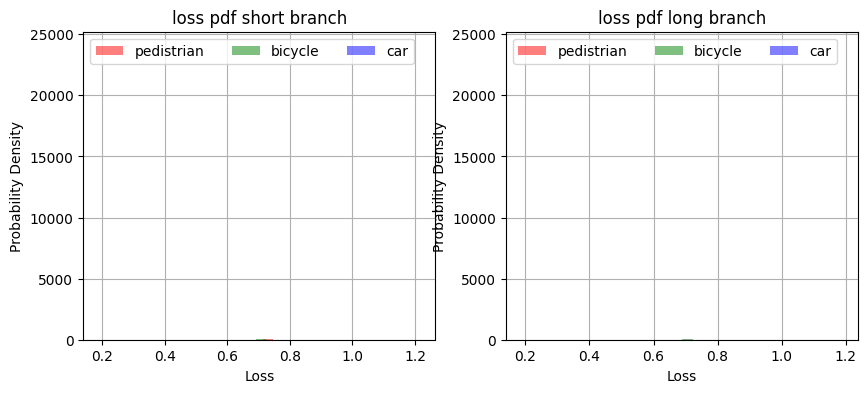

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.hist(np.round(np.array(val_loss_class_0_short),3), bins=30, color='red', alpha=0.5, label='pedistrian',density=True)
plt.hist(np.round(np.array(val_loss_class_1_short),3), bins=30, color='green', alpha=0.5, label='bicycle',density=True)
plt.hist(np.round(np.array(val_loss_class_2_short),3), bins=30, color='blue', alpha=0.5, label='car',density=True)
plt.title('loss pdf short branch')
plt.xlabel('Loss')
plt.ylabel('Probability Density')
plt.legend(loc='upper left', ncol=3)
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(np.round(np.array(val_loss_class_0_long),3), bins=30, color='red', alpha=0.5, label='pedistrian',density=True)
plt.hist(np.round(np.array(val_loss_class_1_long),3), bins=30, color='green', alpha=0.5, label='bicycle',density=True)
plt.hist(np.round(np.array(val_loss_class_2_long),3), bins=30, color='blue', alpha=0.5, label='car',density=True)
plt.title('loss pdf long branch')
plt.xlabel('Loss')
plt.ylabel('Probability Density')
plt.legend(loc='upper left', ncol=3)
plt.grid(True)
plt.show()